## Exploring parameters and variables

Parameters as assumed being somewhat static. But for certain use-cases (sensitivity analysis, calibration) it might be necessary to
explore the parameter space. This can be achived by 'wrapping', inheriting from a process and implementing parameters (present in parameter toml files) as variables.

In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import xsimlab as xs
import xarray as xr
import vmlab
from vmlab.models import fruit_model

In [2]:
from vmlab.processes.carbon_demand import CarbonDemand

# create a new process and change parameter into variable
@xs.process
class CarbonDemandTest(CarbonDemand):
    RGR_fruit_ini = xs.variable()
    def initialize(self):
        super(CarbonDemandTest, self).initialize()
        # overwrite a parameter from carbon_demand.toml
        self.parameters.RGR_fruit_ini = self.RGR_fruit_ini

In [3]:
fruit_model = fruit_model.update_processes({
    'carbon_demand': CarbonDemandTest
}).drop_processes('fruit_quality')

In [4]:
tree = pd.read_csv('../../share/trees/branch_G3.csv')
small_branch = tree[tree.id < 18] # just two fruits

In [5]:
# use a custom weather file
wheater = pd.read_csv('../../share/environment/smartis_lingne_paradis_01.2002_01.2008.csv', sep=';', parse_dates=['Jour'])
wheater = wheater[wheater.Jour <= np.datetime64('2003-06-01')] # drop some rows
wheater.to_csv('tmp/weather.csv', sep=';')

In [6]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=small_branch,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='../../share/setup/fruit_model_branch.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'environment__weather_file': 'tmp/weather.csv'
    },
    output_vars={
        'carbon_allocation__DM_fruit': 'day',
        'carbon_demand__D_fruit': 'day',
        'carbon_demand__RGR_fruit_ini': None,
        'carbon_demand__DM_fruit_0': None
    }
)

In [7]:
# change one or more variables and run the model with each set of variables.
# Since the process 'CarbonDemandTest' is declared inside a notebook batch mode, prallelization does not work
dss = xr.concat([
    vmlab.run(setup.xsimlab.update_vars(fruit_model, {
        'carbon_demand__RGR_fruit_ini': x,
        'carbon_demand__DM_fruit_0': y
    }), fruit_model) for x, y in zip(np.linspace(0.01, 0.02, 5), np.linspace(5, 25, 5))
], dim='test')
dss

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

<xarray.Dataset>
Dimensions:                       (GU: 18, day: 366, test: 5)
Coordinates:
  * GU                            (GU) int32 0 1 2 3 4 5 6 ... 12 13 14 15 16 17
  * day                           (day) datetime64[ns] 2002-06-01 ... 2003-06-01
Dimensions without coordinates: test
Data variables:
    carbon_allocation__DM_fruit   (test, day, GU) float32 0.0 0.0 ... 0.0 0.0
    carbon_demand__DM_fruit_0     (test) float64 5.0 10.0 15.0 20.0 25.0
    carbon_demand__D_fruit        (test, day, GU) float32 0.0 0.0 ... 0.0 0.0
    carbon_demand__RGR_fruit_ini  (test) float64 0.01 0.0125 0.015 0.0175 0.02

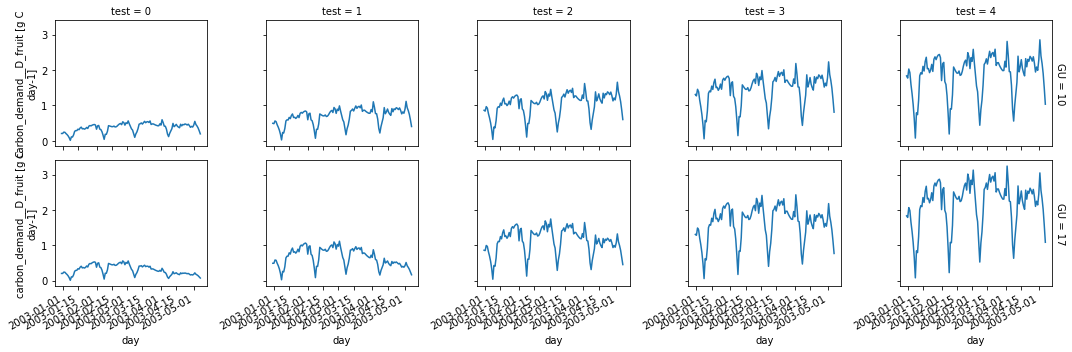

In [8]:
dss.where(dss.carbon_allocation__DM_fruit > 0, drop=True).carbon_demand__D_fruit.plot(col='test', row='GU', figsize=(15, 5))

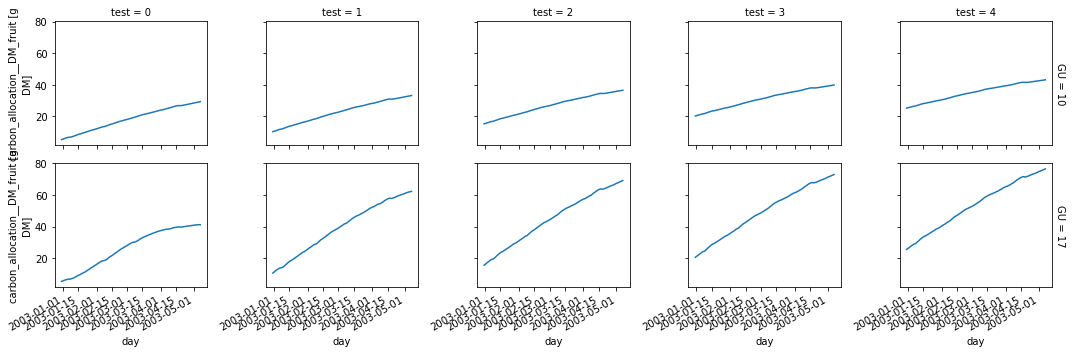

In [9]:
dss.where(dss.carbon_allocation__DM_fruit > 0, drop=True).carbon_allocation__DM_fruit.plot(col='test', row='GU', figsize=(15, 5))